## Machine Learning and Support Vector Machines

In this notebook we are going to look at how SVMs can be applied to the ASAG problem.

Finally, we are going to pull in syntactic as well as semantic information and see how much this influences the results of the problem.

In [272]:
import spacy
import sys
sys.path.append('../')
from importlib import reload
import libs.ml as ml
import libs.utils as utils
import libs.stats as stats
import pandas as pd

In [3]:
df2_en = utils.load_dataframe(language='en',version=2)
nlp_en = spacy.load('en')

In [148]:
import nltk
tmp_model_answers = df2_en['Model Answer'].as_matrix()

def negative_seeds(model_answers, size=500):
    seed_data = nltk.corpus.gutenberg.sents('austen-sense.txt')
    seed_len = len(seed_data)
    indices = np.random.choice(seed_len, size=size, replace=False)
    results = []
    for index in indices:
        sent = seed_data[index]
        ma = np.random.choice(model_answers)
        sa = ' '.join(sent)
        results.append([ma,sa])
        
    return np.array(results)
    
df2_en_x_ext = negative_seeds(tmp_model_answers, size=800)
df2_en_y_ext = np.zeros(800)

In [155]:
## Split up the data
from sklearn.model_selection import train_test_split
    

df2_en_x = df2_en[['Model Answer', 'Student Answer']].as_matrix()
df2_en_y = df2_en['Score'].as_matrix()
df2_en_x2 = np.concatenate((df2_en_x, df2_en_x_ext), axis=0)
df2_en_y2 = np.append(df2_en_y, df2_en_y_ext)

train_x, test_x, train_y, test_y = train_test_split(df2_en_x2, df2_en_y2, test_size=0.2, random_state=42)
print(len(train_x))
print(len(test_x))

2593
649


In [285]:
# Feature Construction
from nltk import edit_distance
import numpy as np
from zss import simple_distance, Node

def get_node_label(node):
    if node.pos_ == 'PRON':
        return node.text.lower()
    else:
        # check for negation
        if 'neg' in [t.dep_ for t in node.children]:
            return 'neg_{}'.format(node.lemma_)
        else:
            return node.lemma_


def to_tree(node):
    if node.n_lefts + node.n_rights > 0:
        label = get_node_label(node)
        zss_Node = Node(label)
        for child in node.children:
            zss_Node.addkid(to_tree(child))
        return zss_Node
    else:
        label = get_node_label(node)
        zss_Node = Node(label)
        return zss_Node
    
def get_root(sent):
    return [t for t in sent if t.dep_ == 'ROOT'][0]


def tree_distance(s1,s2):
    tree1 = to_tree(get_root(s1))
    tree2 = to_tree(get_root(s2))
    return simple_distance(tree1, tree2)


def pos_distance(s1, s2):
    t1 = [t.pos_ for t in s1 if not t.pos_ in ['PUNCT', 'SPACE', 'DET', 'PART']]
    t2 = [t.pos_ for t in s2 if not t.pos_ in ['PUNCT', 'SPACE', 'DET', 'PART']]
    max_ed = np.max([len(t1),len(t2)])
    ed = edit_distance(t2,t1)
    return ed / max_ed

def dep_distance(s1,s2):
    t1 = [t.dep_ for t in s1 if not t.dep_ in ['punct', 'mark', 'aux','']]
    t2 = [t.dep_ for t in s2 if not t.dep_ in ['punct', 'mark', 'aux','']]
    max_ed = np.max([len(t1),len(t2)])

    ed = edit_distance(t2,t1)
    return ed / max_ed

def jaccard_similarity(s1,s2):
    t1 = negate_sentence(s1)
    t2 = negate_sentence(s2)
    
    intersection = set(t1).intersection(set(t2))
    union = set(t1).union(set(t2))
    
    return (len(intersection) / len(union))

def negate_sentence(s):
    result = []
    negate = False
    for t in s:
        prefix = ''
        if negate:
            prefix = 'neg_'
        
        if t.pos_ == 'PUNCT':
            negate = False
        if t.pos_ in ['PUNCT', 'SPACE', 'DET', 'PART']:
            continue
        
        if 'neg' in [x.dep_ for x in t.children] or t.dep_ == 'neg':
            negate = True
        
        if t.pos_ == 'PRON' or t.pos_ == 'PROPN':
            text = t.text.lower()
        else:
            text = t.lemma_
        
        if not t.dep_ in ['neg', 'prep'] and not t.pos_ in ['PRON']:
            label = '{}{}'.format(prefix, text)
            result.append(label)
    return result
        

def lemma_edit_distance(s1,s2):
    t1 = [t.lemma_ for t in s1 if not t.is_stop and not t.pos_ in ['PUNCT', 'SPACE', 'DET', 'PART']]
    t2 = [t.lemma_ for t in s2 if not t.is_stop and not t.pos_ in ['PUNCT', 'SPACE', 'DET', 'PART']]
    max_ed = np.max([len(t1),len(t2)])
    ed = edit_distance(t1,t2)
    return ed / max_ed

def keyphrase_similarity(s1,s2):
    t1 = [t for t in s1 if not t.is_stop and not t.pos_ in ['PUNCT', 'SPACE', 'DET', 'PART']]
    t2 = [t for t in s2 if not t.is_stop and not t.pos_ in ['PUNCT', 'SPACE', 'DET', 'PART']]
    # Find max match
    sims = []
    for x in t1:
        max_sim = 0.0
        for j in t2:
            sim = x.similarity(j) 
            if sim > max_sim:
                max_sim = sim
        sims.append(max_sim)
    for x in t2:
        max_sim = 0.0
        for j in t1:
            sim = x.similarity(j) 
            if sim > max_sim:
                max_sim = sim
        sims.append(max_sim)
    return np.mean(sims)
    
def sentence_similarity(s1,s2):
    return s2.similarity(s1)

In [286]:

def create_features(nlp, data):
    
    features = []
    
    counter = 0
    for row in data:
        model_answer = nlp( row[0] )
        student_answer = nlp( row[1] )
        
        # Syntax Features
        pos_dist = pos_distance(model_answer, student_answer)
        #dep_dist = dep_distance(model_answer, student_answer)
        tree_dist = tree_distance(model_answer, student_answer)
        
        # Semantic Features
        sent_sim = sentence_similarity(model_answer, student_answer)
        keyphrase_sim = keyphrase_similarity(model_answer, student_answer)
        jacc_sim = jaccard_similarity(model_answer, student_answer)
        lemma_sim = lemma_edit_distance(model_answer, student_answer)
        
        vec = []
        vec.append(pos_dist)
        vec.append(tree_dist)
        
        vec.append(jacc_sim)
        vec.append(sent_sim)
        vec.append(keyphrase_sim)
        vec.append(lemma_sim)
        
        features.append(vec)
        
        counter += 1
        if counter % 300 == 0:
            print('batch {}: done.'.format(counter))
    
    return np.array(features)
    
train_x_features = create_features(nlp_en, train_x)
train_x_features.shape

batch 300: done.
batch 600: done.
batch 900: done.
batch 1200: done.
batch 1500: done.
batch 1800: done.
batch 2100: done.
batch 2400: done.


(2593, 6)

(2593, 6)


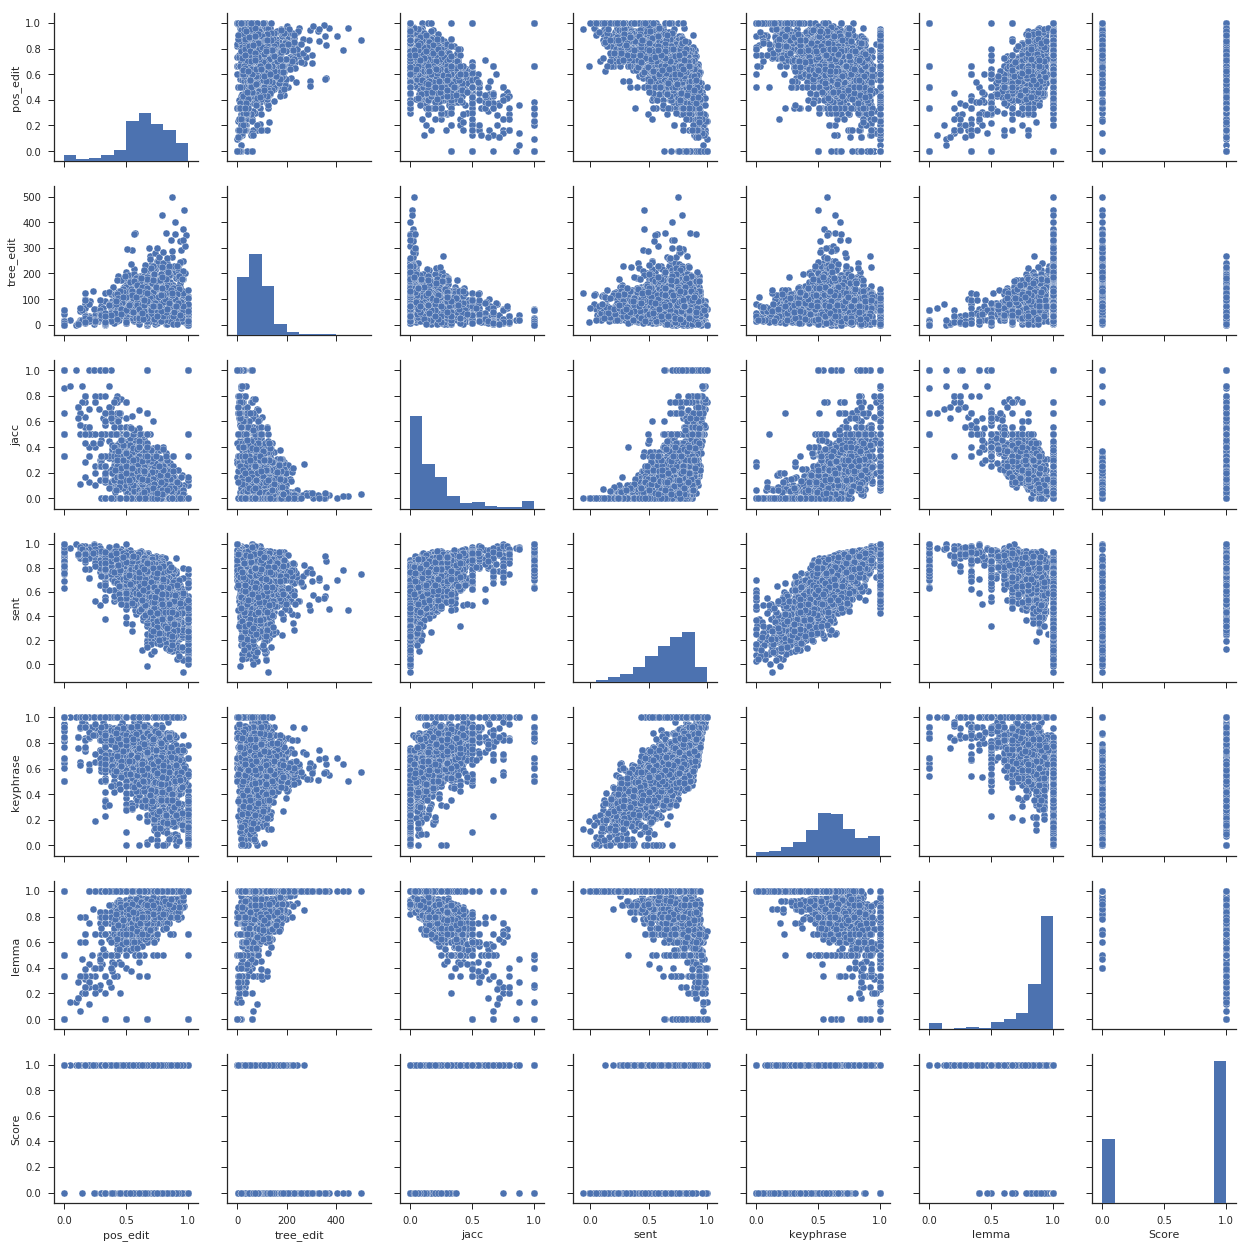

In [284]:
train_y2 = train_y.copy()
test_y2 = test_y.copy()

train_y2[train_y2 < 2.5] = 0
train_y2[train_y2 >= 2.5] = 1

test_y2[test_y2 < 2.5] = 0
test_y2[test_y2 >= 2.5] = 1

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

print(train_x_features.shape)
tmp = pd.DataFrame(train_x_features, columns=['pos_edit', 'tree_edit', 'jacc', 'sent', 'keyphrase', 'lemma'])
tmp['Score'] = pd.Series(train_y2, index=tmp.index)

sns.pairplot(tmp)

In [238]:
from sklearn import svm

clf = svm.SVC(kernel='rbf',gamma=0.4, random_state=42)
clf.fit(train_x_features, train_y2)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.4, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [239]:
## Predict and Test
test_x_features = create_features(nlp_en, test_x)

batch 300: done.
batch 600: done.


In [240]:
test_y_pred = clf.predict(test_x_features)

Accuracy: 77.658%
Precision: 76.479%
Recall: 77.658%
F1-Measure: 75.369%
Pearson's R: 0.40
Cohen's Kappa: 0.37
RMSE: 0.47
MAE: 0.22
Y-True Mean: 0.71
Y-Pred Mean: 0.84
Y-True Std Deviation: 0.45
Y-Pred Std Deviation: 0.37


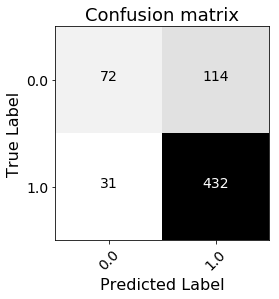

In [241]:
stats.print_big4(test_y2, test_y_pred)
stats.print_stats(test_y2, test_y_pred)
stats.plot_confusion_matrix(stats.cm(test_y2, test_y_pred),classes=np.unique(test_y2))

In [250]:
examples = [
    ['Jane shot Bob', 'Bob shot Jane'],
    ['Jane shot Bob', 'Jane did not shoot Bob'],
    ['Its puts the lotion in the basket', 'this is a long sentence that is meaningless and has virtually no shared characteristics with the model answer'],
    ['A function has a name and a list of arguments', 'functions have many things, they are required to have a name and can optionally have parameters'],
    ['A function has a name and a list of arguments', 'I really have no idea']
]

res = create_features(nlp_en, examples)
y_pred_tmp = clf.predict(res)
print(y_pred_tmp)

[1. 1. 1. 1. 1.]
